In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

In [27]:
IMAGE_SIZE=256
BATCH_SIZE=16
CHANNELS=3
EPOCHS=10

In [28]:
#load data using tf dataset
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [29]:
class_names=dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [30]:
#here our len is 501 because our batch size is 32
len(dataset)

1001

In [31]:
1001*16

16016

(16, 256, 256, 3)
[4 2 3 1 4 6 6 2 0 0 0 5 7 6 4 1]


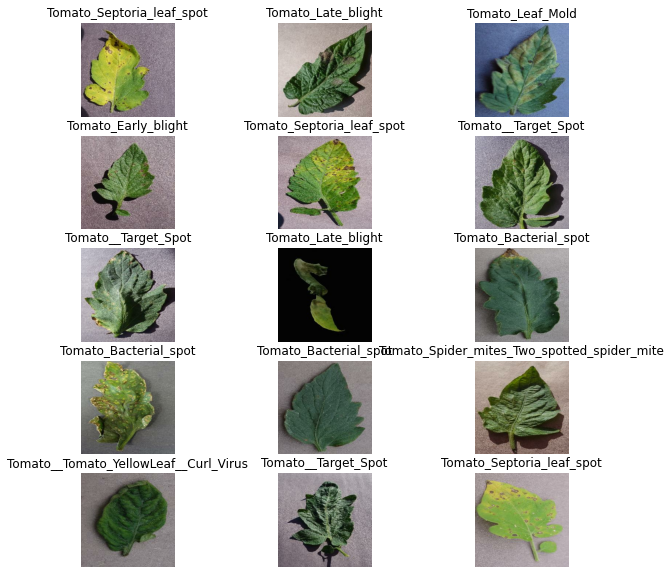

In [32]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(15):
        ax=plt.subplot(5,3,i+1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

In [33]:
#  80% --> for training
#  20%--> for test
#  in testing dataset we use 10% --> for validation & 10% --> for testing purpose

In [34]:
train_size=0.8
len(dataset)*train_size

800.8000000000001

In [35]:
train_ds=dataset.take(800)
len(train_ds)

800

In [36]:
test_ds=dataset.skip(800)
len(test_ds)

201

In [37]:
val_size=0.1
len(dataset)*val_size

100.10000000000001

In [38]:
val_ds=test_ds.take(100)
len(val_ds)

100

In [39]:
test_ds=test_ds.skip(100)
len(test_ds)

101

In [40]:
def get_dataset_partition_tf(ds, train_split=0.8,val_split=0.1, test_split=0.1, shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=15)
    
    train_size=int(train_split * ds_size)
    val_size=int(val_split * ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [41]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [42]:
len(train_ds)

800

In [43]:
len(test_ds)

101

In [44]:
len(val_ds)

100

In [45]:
#caching & prefetch for improvement of performance for both GPU and CPU
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [59]:
# rescalling and resizing Pipeline for all those images

resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [60]:
# data augmentation for making our model robust
# here we apply different transformation to our images like contrast,zoom,Rotation,Horizontal flip
# for example if somone give my model to predict rotated image then my model will predict that as well as.

data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [64]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
num_classes=10

model=models.Sequential([
    resize_and_rescale,
    #data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes,activation='softmax'),
])

model.build(input_shape=input_shape)

In [65]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (16, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (16, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (16, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (16, 60, 60, 64)        

In [66]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [67]:
history=model.fit(
        train_ds,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=val_ds,
        use_multiprocessing=True
    )

Epoch 1/10


2022-07-14 17:02:37.660552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


800/800 [==============================] - ETA: 0s - loss: 1.4577 - accuracy: 0.4865

2022-07-14 17:04:33.962905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


800/800 [==============================] - 131s 149ms/step - loss: 1.4577 - accuracy: 0.4865 - val_loss: 0.9416 - val_accuracy: 0.6762
Epoch 2/10
800/800 [==============================] - 108s 135ms/step - loss: 0.7902 - accuracy: 0.7221 - val_loss: 0.5711 - val_accuracy: 0.8062
Epoch 3/10
800/800 [==============================] - 107s 134ms/step - loss: 0.5625 - accuracy: 0.8012 - val_loss: 0.4118 - val_accuracy: 0.8512
Epoch 4/10
800/800 [==============================] - 110s 137ms/step - loss: 0.4464 - accuracy: 0.8439 - val_loss: 0.3891 - val_accuracy: 0.8662
Epoch 5/10
800/800 [==============================] - 110s 137ms/step - loss: 0.3605 - accuracy: 0.8721 - val_loss: 0.2925 - val_accuracy: 0.8981
Epoch 6/10
800/800 [==============================] - 108s 135ms/step - loss: 0.3021 - accuracy: 0.8935 - val_loss: 0.2873 - val_accuracy: 0.9025
Epoch 7/10
800/800 [==============================] - 107s 134ms/step - loss: 0.2547 - accuracy: 0.9121 - val_loss: 0.2738 - val_accura

In [68]:
scores=model.evaluate(test_ds)

101/101 [==============================] - 15s 47ms/step - loss: 0.1391 - accuracy: 0.9524


In [69]:
scores

[0.13914567232131958, 0.952351450920105]

In [70]:
history

In [72]:
 history.params

{'verbose': 1, 'epochs': 10, 'steps': 800}

In [73]:
 history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [74]:
 history.history['accuracy']

[0.48651817440986633,
 0.7220789194107056,
 0.8011723160743713,
 0.8439233899116516,
 0.8720594048500061,
 0.8934739828109741,
 0.9120750427246094,
 0.9182493090629578,
 0.9323954582214355,
 0.9445095658302307]

In [75]:
 history.history['loss']

[1.4576681852340698,
 0.7902159690856934,
 0.5625436902046204,
 0.44637441635131836,
 0.36048418283462524,
 0.3020996153354645,
 0.2547331154346466,
 0.23389634490013123,
 0.1987767219543457,
 0.16051679849624634]

In [76]:
history.history['val_loss']

[0.9416386485099792,
 0.5711088180541992,
 0.41179195046424866,
 0.3890838921070099,
 0.29253044724464417,
 0.2872938811779022,
 0.2738229036331177,
 0.18931613862514496,
 0.1850566864013672,
 0.12872156500816345]

In [77]:
history.history['val_accuracy']

[0.6762499809265137,
 0.8062499761581421,
 0.8512499928474426,
 0.8662499785423279,
 0.8981249928474426,
 0.9024999737739563,
 0.8999999761581421,
 0.9331249594688416,
 0.9387499690055847,
 0.9574999809265137]

In [78]:
#now i will plot this all parameters in nice matplotlib graph
acc=history.history['accuracy']
loss=history.history['loss']

val_accuracy=history.history['val_accuracy']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'training and validation loss')

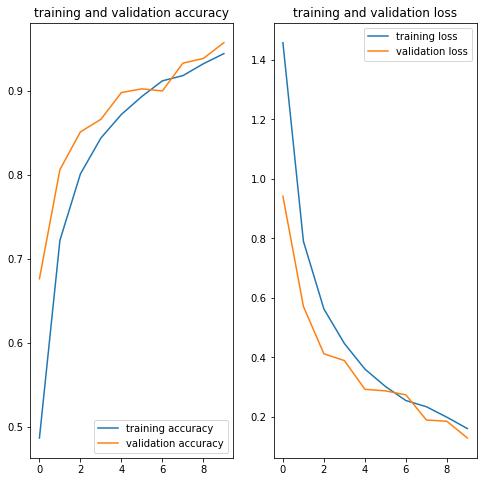

In [92]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc,label='training accuracy')
plt.plot(range(EPOCHS), val_accuracy,label='validation accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss,label='training loss')
plt.plot(range(EPOCHS), val_loss,label='validation loss')
plt.legend(loc='upper right')
plt.title('training and validation loss')

In [98]:
import numpy as np

first image to predict
first image's actual label: Tomato_Late_blight
predicted label: Tomato_Late_blight


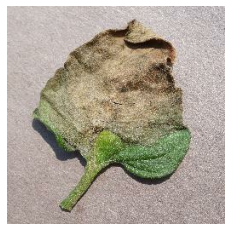

In [108]:
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_lable=labels_batch[0]
    
    print("first image to predict")
    plt.imshow(first_image)
    plt.axis('off')
    print("first image's actual label:", class_names[first_lable])
    
    batch_prediction=model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [120]:
#creating a function which is take input as image and return a predicted class name and confidence level
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

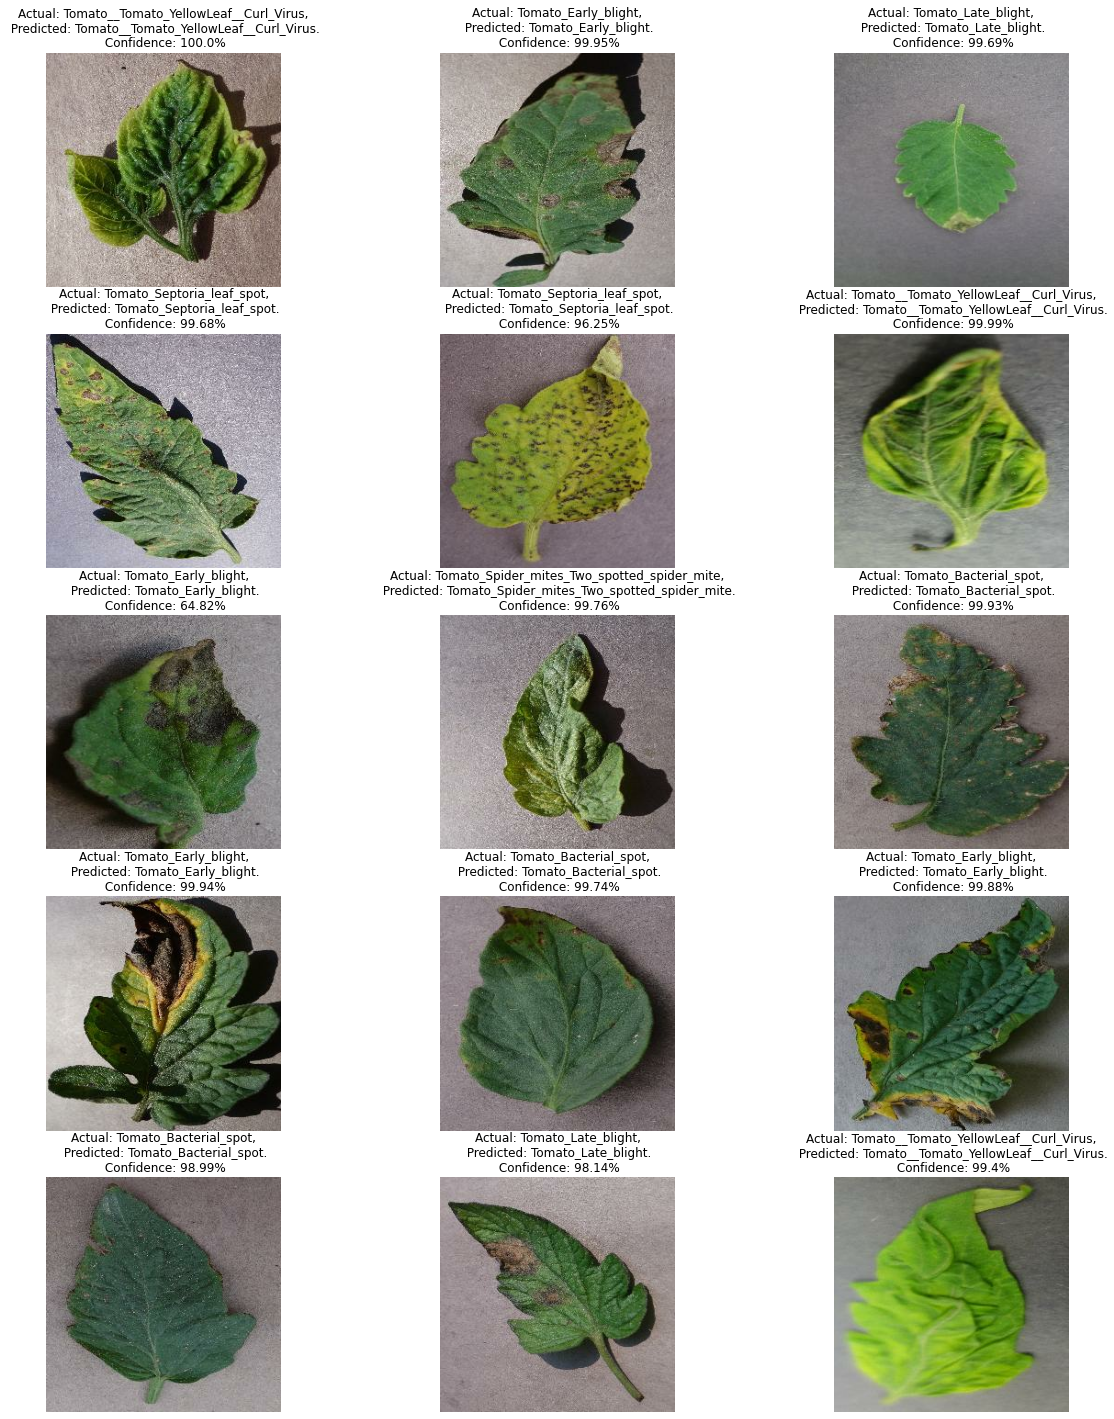

In [127]:
plt.figure(figsize=(20, 25))
for images, labels in test_ds.take(1):
    for i in range(15):
        ax = plt.subplot(5, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [128]:
model_version=1
model.save(f"./Models/{model_version}")

2022-07-14 18:26:09.223096: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Models/1/assets


In [129]:
model_version=2
model.save(f"./Models/{model_version}")

INFO:tensorflow:Assets written to: ./Models/2/assets


In [135]:
import os
model_version=max([int(i) for i in os.listdir("./Models/")+[0]])+1
model.save(f"./Models/{model_version}")

INFO:tensorflow:Assets written to: ./Models/4/assets
